# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install imageio
!pip install opencv-python

In [3]:
import numpy as np
import os
from cv2 import imread, resize, imshow
from matplotlib import pyplot as plt
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

2024-05-05 19:00:49.797087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 19:00:49.797212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 19:00:50.079380: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('/kaggle/input/gesture-recognition-dataset/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/gesture-recognition-dataset/Project_data/val.csv').readlines())

batch_size = 10

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(30)
    x = len(img_idx)
    y = 60
    z = 80
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                t_list_index = folder + (batch*batch_size)
                imgs = os.listdir(source_path+'/'+ t[t_list_index].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[t_list_index].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # Reshaping it to y*z (or 60*80) pixels
                    image = resize(image, dsize=(z,y))
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5)) / (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5)) / (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5)) / (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5)) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        next_t_index = (t_list_index+1)
        last_batch_size = len(t) - (t_list_index+1)
        batch_data = np.zeros((last_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((last_batch_size,5)) # batch_labels is the one hot representation of the output
        for folder, t_list_index in enumerate( range(next_t_index, len(t)) ): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[t_list_index].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[t_list_index].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image = resize(image, dsize=(z,y))
                
                batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5)) / (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5)) #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5)) / (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5)) #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5)) / (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5)) #normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels
            


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'

train_path = '/kaggle/input/gesture-recognition-dataset/Project_data/train'
val_path = '/kaggle/input/gesture-recognition-dataset/Project_data/val'

curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [8]:
generator_test = generator(train_path, train_doc, batch_size)
batch_data, batch_labels = generator_test.__next__()
batch_data.shape

Source path =  /kaggle/input/gesture-recognition-dataset/Project_data/train ; batch size = 10


(10, 30, 60, 80, 3)

Source path =  /kaggle/input/gesture-recognition-dataset/Project_data/train ; batch size = 10


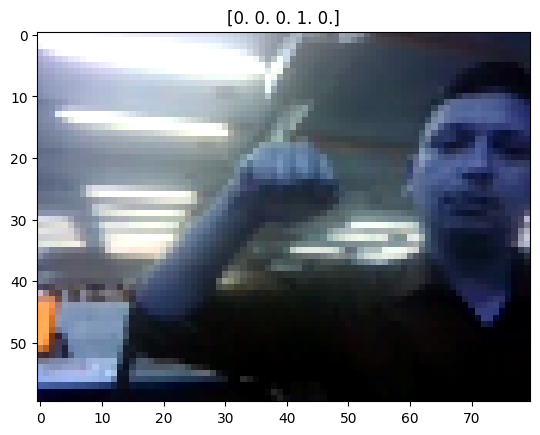

In [9]:
generator_test = generator(train_path, train_doc, batch_size)
batch_data, batch_labels = generator_test.__next__()
    
for i in range(1):
    plt.imshow(batch_data[i, 15, :, :, :])
    plt.title(str(batch_labels[i,:]))
    plt.show()

## Model 
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, InputLayer
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

### Model 1
#### 3D Convolution

In [11]:
#write your model here

model = Sequential(layers=[
    InputLayer(shape=(30, 60, 80, 3)),
    Conv3D(3, kernel_size=(3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2,2,2)),
    Flatten(),
    Dense(5, activation='relu'),
    Dense(5, activation='softmax')
])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
optimiser = optimizers.Adam(learning_rate=0.1) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 60, 80, 3)  │           246 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 30, 40, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 54000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │       270,005 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,281 (1.03 MB)

 Trainable params: 270,281 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init_conv3d' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001, min_delta=0.01, mode="min") # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print(f'steps_per_epoch: {steps_per_epoch}')
print(f'validation_steps: {validation_steps}')

steps_per_epoch: 67
validation_steps: 10


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
num_epochs = 50
print ('# epochs =', num_epochs)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
history = model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

# epochs = 50
Num GPUs Available:  2
Source path =  /kaggle/input/gesture-recognition-dataset/Project_data/train ; batch size = 10
Epoch 1/50
 1/67 ━━━━━━━━━━━━━━━━━━━━ 5:27 5s/step - categorical_accuracy: 0.3000 - loss: 1.5892

I0000 00:00:1714935687.245336     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714935687.260962     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.1700 - loss: 81.8733Source path =  /kaggle/input/gesture-recognition-dataset/Project_data/val ; batch size = 10


W0000 00:00:1714935941.896609     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to model_init_conv3d_2024-05-0519_01_05.270519/model-00001-23.18645-0.15988-1.60680-0.23000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 292s 4s/step - categorical_accuracy: 0.1699 - loss: 81.0102 - val_categorical_accuracy: 0.2300 - val_loss: 1.6068 - learning_rate: 0.1000
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2332 - loss: 1.6152
Epoch 2: saving model to model_init_conv3d_2024-05-0519_01_05.270519/model-00002-1.62147-0.20965-nan-0.18889.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - categorical_accuracy: 0.2329 - loss: 1.6153 - val_categorical_accuracy: 0.1889 - val_loss: nan - learning_rate: 0.1000
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.1940 - loss: 1.6287
Epoch 3: saving model to model_init_conv3d_2024-05-0519_01_05.270519/model-00003-1.62125-0.20664-nan-0.16667.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - categorical_accuracy: 0.1942 - loss: 1.6286 - val_categorical_accuracy: 0.1667 - val_loss: 

KeyboardInterrupt: 

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 2
#### 2D Convolution + RNN

In [ ]:
#write your model here

model = Sequential(layers=[
    InputLayer(shape=(30, 60, 80, 3)),
    TimeDistributed( Conv2D(3, kernel_size=(3,3), activation='relu', padding='same' )),
    TimeDistributed( MaxPooling2D(pool_size=(2,2)) ),
    TimeDistributed(Flatten()),
    GRU(5, activation='relu'),
    Dense(5, activation='relu'),
    Dense(5, activation='softmax')
])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_conv2d_rnn' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print(f'steps_per_epoch: {steps_per_epoch}')
print(f'validation_steps: {validation_steps}')

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
num_epochs = 2
print ('# epochs =', num_epochs)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
history = model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()